# Libraries

In [1]:
import os
import sys
import glob


import numpy as np
import pandas as pd
import copy as cp

import scipy
import scipy.signal

from astropy import units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.io.votable import from_table, parse_single_table, parse
from astropy.coordinates import SkyCoord

from reproject import reproject_from_healpix, reproject_interp, reproject_adaptive
import healpy as hp


from spectral_cube import SpectralCube

import pickle
import shutil

import matplotlib.pyplot as plt
import matplotlib        as mpl
from matplotlib.patches import Ellipse
from matplotlib.ticker import AutoMinorLocator

import matplotlib.pyplot as plt
from matplotlib import patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

from pathlib import Path
import more_itertools as mit

import seaborn as sns

In [2]:
# Set the font family for math symbols
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'


plt.rc('text', usetex=False)
plt.rc('font', family='serif')

# Display all colums
pd.set_option('display.max_columns', None)

# Paths

In [ ]:
base = Path.home()
askap = base / 'ANU' / 'ASKAP'
data_path = askap / 'data'
LMC_data_path = data_path / 'LMC'
LMC_GASKAP_data = LMC_data_path / 'lmc_gaskap'

cont_data_path = data_path / 'cont'
LMC_bridge_data = LMC_data_path / 'bridge'
GASS_em_spectra_path = LMC_data_path / 'neighbour_emission_spectra'
GASS_data_path = LMC_data_path / 'GASS'

SMC = askap / 'SMC'
SMC_data_path = data_path / 'SMC'
SMC_fg_data_path = SMC_data_path / 'fg'
SMC_fg_abs_data_path = SMC_fg_data_path / 'spectra'

hires_data = LMC_data_path / 'hires'
em_spectra_path = hires_data / 'neighbour_emission_spectra'
hires_results = hires_data / 'results'
hires_em_data = hires_data / 'cube'
hires_em_subcube_data = hires_em_data / 'subcubes'
hires_abs_data = hires_data / 'abs'
hires_em_profile_path = hires_data / 'em_profiles'
abscatv2_data_path = hires_data / 'abscatv2'
abs_dr3_data_path = hires_data / 'absdr3'

mwmc_data_path = data_path / 'mwmc'
mwmc_gaskap_path = mwmc_data_path / 'lmc_gaskap'

bridge_hires_abs_data = hires_abs_data / 'bridge'
LMC_hires_abs_data = hires_abs_data / 'lmc'

abs_path = mwmc_data_path / 'absorption'

abs_path = mwmc_data_path / 'absorption'
BIGHICAT_data_path = data_path / 'BIGHICAT'

# Absorption catalog Phase 2 version 2
print(abscatv2_data_path)

# Absorption catalog  version 3
print(abs_dr3_data_path)

# Modules

In [ ]:
script_dir = os.path.dirname(os.path.realpath('__file__'))
parent_dir = os.path.abspath(Path(script_dir) / os.pardir)
print('script_dir: ', script_dir)
print('parent_dir: ', parent_dir)
gaussfit_dir = Path(parent_dir) / 'gaussfit'
print('gaussfit_dir: ', gaussfit_dir)
sys.path.append(parent_dir)
module_dir = Path(parent_dir) / 'gaussfit' / 'modules'
sys.path.append(module_dir)

print('script_dir: ', script_dir)
print('parent_dir: ', parent_dir)
print('gaussfit_dir: ', gaussfit_dir)

script_dir

In [5]:
import libs.fitlibs as fitlibs
import libs.functions as fcn
import config.config as cf

# For plotting

In [6]:
# Approximate locations of LMC and SMC
SMC_xcirc, SMC_ycirc = cf.SMC['circ']
LMC_xcirc, LMC_ycirc = cf.LMC['circ']

In [7]:
# Circle
def hcircle(x, y, r):
    theta = np.linspace(1.365*np.pi, 1.55*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

# Circle
def vcircle(x, y, r):
    theta = np.linspace(1.73*np.pi, 1.87*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

gl_ch = 295.
gb_ch = 21.8
R_ch  = 59.

gl_cv = 238.
gb_cv = -5.
R_cv  = 57.


ch_xcirc, ch_ycirc = hcircle(gl_ch, gb_ch, R_ch)
cv_xcirc, cv_ycirc = vcircle(gl_cv, gb_cv, R_cv)

In [8]:
lmc_glon = [270., 308.]
lmc_glat = [-48.99, -26.45]

gl_boundary = np.array([297., 302., 305., 308., 305., 297., 298., 295., 292., 294., 285., 283.5, 271.5, 271., 288.5, 290., 295., 297.])
gb_boundary = np.array([-36., -35., -40., -42.5, -48.5, -46.2, -43., -38.25, -39.8, -44.5, -45.9, -40.8, -41.5, -29., -26.9, -32., -31., -36.])

# Number of observed fields

In [ ]:
all_dirs = glob.glob( str(hires_abs_data / '*' / '') )

print(f'Number of folders: {len(all_dirs)}')
all_dirs

In [10]:
all_dir_names = [x.replace(str(hires_abs_data), '').replace('/', '') for x in all_dirs]
fields = sorted(list(set([x for x in all_dir_names])))
field_idx = [int(x.replace('sb', '')) for x in fields]
n_fields = len(fields)

print('Number of fields: ', n_fields)
print(fields)

Number of fields:  10
['sb30665', 'sb33047', 'sb38215', 'sb38373', 'sb38466', 'sb38509', 'sb38758', 'sb38791', 'sb38814', 'sb38845']


# Fcn

In [11]:
def boostrap_resampling_err(data):
    n_bootstrap_samples = 1000

    # Initialize array to store resampled medians
    resampled_medians = np.empty(n_bootstrap_samples)

    # Initialize array to store resampled means
    resampled_means = np.empty(n_bootstrap_samples)

    # Perform bootstrap resampling
    for i in range(n_bootstrap_samples):
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        resampled_medians[i] = np.median(bootstrap_sample)
        resampled_means[i] = np.mean(bootstrap_sample)
    # End - for

    median_uncertainty = np.std(resampled_medians)
    mean_uncertainty = np.std(resampled_means)

    return mean_uncertainty, median_uncertainty

In [12]:
# linear model
def linear_fcn(p, x):
    m, b = p
    return m*x + b

# Read BIGHICAT

In [13]:
bighicat_file = BIGHICAT_data_path / 'all_unique_LOS_new.csv'
bighicat_df = pd.read_csv(bighicat_file)
bighicat_nrows, bighicat_ncols = bighicat_df.shape
print(bighicat_nrows, bighicat_ncols)

374 30


In [14]:
bighicat_df

,source,survey,lon,lat,ra,dec,NHI_LOS,f_CNM_LOS,f_WNM_LOS,NHI_CNM_LOS,NHI_WNM_LOS,int_Ts,e_int_Ts,tau_peak,tau_sensitivity,ncomps,EBV_GNILC,e_EBV_GNILC,AV_GNILC,e_AV_GNILC,EBV_2013,AV_2013,ICO10_1,ICO10_2,ICO21,Td,e_Td,qPAH,f_CNM_LOS_KOK14,e_f_CNM_LOS_KOK14
0,J0022,21-SPONGE,107.461730,-61.748239,5.605941,0.248934,2.642248,0.040872,0.627534,0.107994,1.658101,914.225482,97.669608,0.025003,0.000991,4.0,0.025335,0.000706,0.078539,0.002189,0.032554,0.100917,33.513996,-0.105451,-0.000096,18.925838,0.358167,0.025,0.065020,0.034327
1,3C018A,21-SPONGE,118.623255,-52.731718,10.211263,10.051389,6.287702,0.523649,0.476351,3.292549,2.995154,144.529741,2.137539,0.622906,0.001829,4.0,0.161014,0.010132,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042,0.581377,0.263721
2,3C018B,21-SPONGE,118.616421,-52.718907,10.206185,10.063889,6.273332,0.525139,0.474861,3.294371,2.978961,145.948777,3.302026,0.641714,0.002671,2.0,0.161014,0.010132,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042,0.571241,0.258198
3,3C041A,21-SPONGE,131.378783,-29.074651,21.686793,33.217306,5.463896,0.004445,0.630555,0.024289,3.445285,706.217000,92.798770,0.038991,0.002728,3.0,0.054415,0.002150,0.168688,0.006666,0.075769,0.234883,5.707996,-0.018077,0.084511,19.713444,0.543411,0.050,0.092098,0.045187
4,3C041B,21-SPONGE,131.373859,-29.069848,21.682609,33.222722,5.468773,0.161569,0.838431,0.883582,4.585191,694.696715,129.059712,0.057092,0.004103,3.0,0.054201,0.002183,0.168024,0.006768,0.075073,0.232728,0.130720,0.259304,0.039420,19.725590,0.554813,0.052,0.095320,0.047690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,J17305,MACH,62.989300,31.515300,262.725150,38.197218,3.340000,0.080000,0.920000,0.267200,3.072800,308.619949,NaN,0.280609,0.008845,1.0,0.041178,0.001210,0.127653,0.003751,0.048668,0.150870,-6.611929,-0.689890,0.163849,18.828846,0.375549,0.055,NaN,NaN
370,J17395,MACH,74.222100,31.396300,264.987619,47.632615,2.100000,0.010000,0.990000,0.021000,2.079000,495.054726,NaN,0.101940,0.003759,1.0,0.028716,0.000767,0.089020,0.002379,0.024448,0.075789,-4.240314,-0.046202,-1.399806,16.961460,0.294231,0.074,NaN,NaN
371,J17403,MACH,79.563300,31.748300,265.153694,52.195089,2.930000,0.010000,0.990000,0.029300,2.900700,312.439362,NaN,0.170193,0.005946,2.0,0.044000,0.001390,0.136399,0.004308,0.049554,0.153618,-17.370651,-0.365892,-1.449508,18.306437,0.388935,0.059,NaN,NaN
372,J17422,MACH,81.770200,31.613400,265.597628,54.059010,3.160000,0.060000,0.940000,0.189600,2.970400,682.772331,NaN,0.087578,0.009846,1.0,0.044939,0.001173,0.139312,0.003635,0.046919,0.145447,-13.981676,0.407484,-0.203576,18.122824,0.315143,0.052,NaN,NaN


In [15]:
bighicat_df.columns

Index(['source', 'survey', 'lon', 'lat', 'ra', 'dec', 'NHI_LOS', 'f_CNM_LOS',
       'f_WNM_LOS', 'NHI_CNM_LOS', 'NHI_WNM_LOS', 'int_Ts', 'e_int_Ts',
       'tau_peak', 'tau_sensitivity', 'ncomps', 'EBV_GNILC', 'e_EBV_GNILC',
       'AV_GNILC', 'e_AV_GNILC', 'EBV_2013', 'AV_2013', 'ICO10_1', 'ICO10_2',
       'ICO21', 'Td', 'e_Td', 'qPAH', 'f_CNM_LOS_KOK14', 'e_f_CNM_LOS_KOK14'],
      dtype='object')

In [16]:
bighicat_fcnm = bighicat_df['f_CNM_LOS']
bighicat_av = bighicat_df['AV_2013']

### BIGHICAT high latitudes

In [18]:
blim = 20. # degrees, high Galactic latitude
hghlat_df = bighicat_df[abs(bighicat_df.lat) > blim]
hghlat_df.head()

,source,survey,lon,lat,ra,dec,NHI_LOS,f_CNM_LOS,f_WNM_LOS,NHI_CNM_LOS,NHI_WNM_LOS,int_Ts,e_int_Ts,tau_peak,tau_sensitivity,ncomps,EBV_GNILC,e_EBV_GNILC,AV_GNILC,e_AV_GNILC,EBV_2013,AV_2013,ICO10_1,ICO10_2,ICO21,Td,e_Td,qPAH,f_CNM_LOS_KOK14,e_f_CNM_LOS_KOK14
0,J0022,21-SPONGE,107.461730,-61.748239,5.605941,0.248934,2.642248,0.040872,0.627534,0.107994,1.658101,914.225482,97.669608,0.025003,0.000991,4.0,0.025335,0.000706,0.078539,0.002189,0.032554,0.100917,33.513996,-0.105451,-0.000096,18.925838,0.358167,0.025,0.065020,0.034327
1,3C018A,21-SPONGE,118.623255,-52.731718,10.211263,10.051389,6.287702,0.523649,0.476351,3.292549,2.995154,144.529741,2.137539,0.622906,0.001829,4.0,0.161014,0.010132,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042,0.581377,0.263721
2,3C018B,21-SPONGE,118.616421,-52.718907,10.206185,10.063889,6.273332,0.525139,0.474861,3.294371,2.978961,145.948777,3.302026,0.641714,0.002671,2.0,0.161014,0.010132,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042,0.571241,0.258198
3,3C041A,21-SPONGE,131.378783,-29.074651,21.686793,33.217306,5.463896,0.004445,0.630555,0.024289,3.445285,706.217000,92.798770,0.038991,0.002728,3.0,0.054415,0.002150,0.168688,0.006666,0.075769,0.234883,5.707996,-0.018077,0.084511,19.713444,0.543411,0.050,0.092098,0.045187
4,3C041B,21-SPONGE,131.373859,-29.069848,21.682609,33.222722,5.468773,0.161569,0.838431,0.883582,4.585191,694.696715,129.059712,0.057092,0.004103,3.0,0.054201,0.002183,0.168024,0.006768,0.075073,0.232728,0.130720,0.259304,0.039420,19.725590,0.554813,0.052,0.095320,0.047690


In [19]:
hghlat_df.columns

Index(['source', 'survey', 'lon', 'lat', 'ra', 'dec', 'NHI_LOS', 'f_CNM_LOS',
       'f_WNM_LOS', 'NHI_CNM_LOS', 'NHI_WNM_LOS', 'int_Ts', 'e_int_Ts',
       'tau_peak', 'tau_sensitivity', 'ncomps', 'EBV_GNILC', 'e_EBV_GNILC',
       'AV_GNILC', 'e_AV_GNILC', 'EBV_2013', 'AV_2013', 'ICO10_1', 'ICO10_2',
       'ICO21', 'Td', 'e_Td', 'qPAH', 'f_CNM_LOS_KOK14', 'e_f_CNM_LOS_KOK14'],
      dtype='object')

In [20]:
bighicat_tau = hghlat_df.tau_peak.values
bighicat_sigtau = hghlat_df.tau_sensitivity.values

In [21]:
bighicat_hghlat_fcnm = hghlat_df.f_CNM_LOS.values
bighicat_hghlat_nhi = hghlat_df.NHI_LOS.values

In [22]:
print(hghlat_df.survey.value_counts().sum())
print(hghlat_df.survey.value_counts())

224
GMRT04          75
MACH            44
Millennium03    39
21-SPONGE       36
Per14           16
TauGem19        14
Name: survey, dtype: int64


### BIGHICAT components

In [25]:
bighicat_cpn_file = BIGHICAT_data_path / 'all_unique_CNM_det_gaussian_components_new.csv'
bighicat_cpn_df = pd.read_csv(bighicat_cpn_file)
bighicat_cpn_nrows, bighicat_cpn_ncols = bighicat_cpn_df.shape
print(bighicat_cpn_nrows, bighicat_cpn_ncols)

1370 41


In [26]:
bighicat_cpn_df.columns

Index(['source', 'survey', 'lon', 'lat', 'tau', 'e_tau', 'fwhm_abs',
       'e_fwhm_abs', 'v_abs', 'e_v_abs', 'Tb', 'e_Tb', 'fwhm_em', 'e_fwhm_em',
       'v_em', 'e_v_em', 'NHI', 'e_NHI', 'Ts', 'e_Ts', 'ncomps', 'NHI_LOS',
       'f_CNM_LOS', 'f_CNM_LOS_KOK14', 'e_f_CNM_LOS_KOK14', 'f_WNM_LOS',
       'NHI_CNM_LOS', 'NHI_WNM_LOS', 'int_Ts', 'EBV_GNILC', 'e_EBV_GNILC',
       'AV_GNILC', 'e_AV_GNILC', 'EBV_2013', 'AV_2013', 'ICO10_1', 'ICO10_2',
       'ICO21', 'Td', 'e_Td', 'qPAH'],
      dtype='object')

In [27]:
surveys = bighicat_cpn_df.survey.unique().tolist()
surveys

['21-SPONGE',
 'Millennium03',
 'Per14',
 'GMRT04',
 'TauGem19',
 'RiegelCrutcher18',
 'MACH']

In [29]:
bighicat_ts     = bighicat_cpn_df.Ts.values
bighicat_sigts  = bighicat_cpn_df.e_Ts.values
bighicat_tau    = bighicat_cpn_df.tau.values
bighicat_sigtau = bighicat_cpn_df.e_tau.values

bighicat_gb = np.abs(bighicat_cpn_df.lat.values)

# GASKAP absorption: Read table Data Release 3 beta

In [53]:
spectra_filename = abs_dr3_data_path / 'gaskap_abs_spectra_dr3b.csv'
print(spectra_filename)
df = pd.read_csv(spectra_filename)
nsrcs, ncols = df.shape
print(f'Number of rows {nsrcs},\n Number of columns: {ncols}')
df.head(5)

/Users/kiemhiep/ANU/ASKAP/data/LMC/hires/absdr3/gaskap_abs_spectra_dr3b.csv
Number of rows 2714,
 Number of columns: 33


,id,comp_name,component_id,ra,dec,glon,glat,rating,flux_peak,flux_int,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,min_opacity,vel_min_opacity,peak_tau,e_peak_tau,has_mw_abs,has_other_abs,semi_maj_axis,semi_min_axis,pa,n_h,noise_flag,continuum_slope,field,all_sbids,sbid,mw_detection,saturated
0,0,J005611-710706,SB30665_component_1a,14.047482,-71.118446,302.378462,-46.004698,A,519.130005,442.507996,0.003324,0.004476,0.120743,5.142489,1.019657,144.0,0.898914,-0.788959,0.106568,0.005696,True,True,4.80,4.215,33.869999,1.236612e+21,False,0.000923,M344-11,30665,30665,True,False
1,8,J011049-731427,SB30665_component_3a,17.707468,-73.240921,300.996592,-43.814386,A,457.480988,596.744995,0.001633,0.005186,0.472219,23.407247,1.019347,119.0,0.547128,158.554968,0.603072,0.014683,True,True,5.79,5.350,54.860001,4.874624e+21,False,-0.000770,M344-11,30665,30665,True,False
2,9,J011056-731406,SB30665_component_3b,17.735945,-73.235151,300.984436,-43.819266,A,115.037003,208.171005,0.000281,0.022776,0.478756,5.717874,1.071266,93.0,0.592510,159.534285,0.523387,0.058836,False,True,7.48,5.745,39.880001,4.874624e+21,False,-0.000363,M344-11,30665,30665,False,False
3,10,J004048-714600,SB30665_component_4a,10.200474,-71.766489,304.115161,-45.337319,A,428.450012,463.325989,0.002056,0.008573,0.113398,3.477934,1.025324,76.0,0.911926,0.889198,0.092196,0.011053,True,False,5.23,4.905,175.600006,4.498524e+20,False,0.000679,M344-11,30665,30665,True,False
4,11,J005732-741242,SB30665_component_5a,14.385728,-74.211897,302.365011,-42.909634,A,428.031006,461.653015,0.001720,0.008202,0.514969,23.851180,1.020722,65.0,0.505753,139.606872,0.681707,0.017343,True,True,5.23,4.895,175.509995,5.650006e+20,False,0.000971,M344-11,30665,30665,True,False


In [54]:
df = df[ df['sbid'].isin(field_idx) ]
nrows, ncols = df.shape
df.shape

(2714, 33)

In [58]:
field_ids = df['sbid'].unique()
print(f'Number of fields: {len(field_ids)}')
fields = ['sb'+str(x) for x in field_ids]
print('Fields: ', ', '.join([str(x) for x in field_ids]))
print()
print('Number of sources/sightlines in each field:')
df.groupby(['sbid'])['sbid'].count()

Number of fields: 10
Fields:  30665, 33047, 38814, 38791, 38845, 38215, 38373, 38466, 38758, 38509

Number of sources/sightlines in each field:


sbid
30665    346
33047    290
38215    268
38373    257
38466    261
38509    270
38758    200
38791    297
38814    242
38845    283
Name: sbid, dtype: int64

In [59]:
print(f"Types of ratings: {df['rating'].unique()}")

Types of ratings: ['A' 'B' 'C' 'D']


In [60]:
df.groupby(['rating'])['comp_name'].count()

rating
A     294
B    1869
C     343
D     208
Name: comp_name, dtype: int64

In [61]:
# All sources
sources = df['comp_name'].unique()
print(f'Number of sources toward LMC: {len(sources)}')
print(f'Sources: {sources}')

Number of sources toward LMC: 2714
Sources: ['J005611-710706' 'J011049-731427' 'J011056-731406' ... 'J045340-751015'
 'J060302-715904' 'J051901-715032']


In [62]:
df[ df['has_mw_abs'] == True ]['comp_name'].unique().shape

(473,)

In [63]:
field_ids = df['sbid'].unique()
nfields = len(field_ids)
print(f'Number of fields: {nfields}')
fields = ['sb'+str(x) for x in field_ids]
print('Fields: ', ', '.join([str(x) for x in field_ids]))
print()
print('Number of sources/sightlines in each field:')
df.groupby(['sbid'])['sbid'].count()

Number of fields: 10
Fields:  30665, 33047, 38814, 38791, 38845, 38215, 38373, 38466, 38758, 38509

Number of sources/sightlines in each field:


sbid
30665    346
33047    290
38215    268
38373    257
38466    261
38509    270
38758    200
38791    297
38814    242
38845    283
Name: sbid, dtype: int64

In [64]:
src_ra = df['ra'].values
src_dec = df['dec'].values

src_gl = df['glon'].values
src_gb = df['glat'].values

src_list = df['comp_name'].values
print(len(src_list))

2714


In [65]:
fields_series = df['sbid'].value_counts()
fields_series

30665    346
38791    297
33047    290
38845    283
38509    270
38215    268
38466    261
38373    257
38814    242
38758    200
Name: sbid, dtype: int64

In [66]:
# All sources
sources = df['comp_name'].unique()
print(f'Number of sources toward LMC: {len(sources)}')
print(f'Sources: {sources}')

Number of sources toward LMC: 2714
Sources: ['J005611-710706' 'J011049-731427' 'J011056-731406' ... 'J045340-751015'
 'J060302-715904' 'J051901-715032']


In [68]:
sbid = fields_series.index.to_list()
print(f'Fields: {sbid}')
sbid_counts = fields_series.values
print(f'sbid_counts: {sbid_counts}')

Fields: [30665, 38791, 33047, 38845, 38509, 38215, 38466, 38373, 38814, 38758]
sbid_counts: [346 297 290 283 270 268 261 257 242 200]


Number of sightlines: 2714


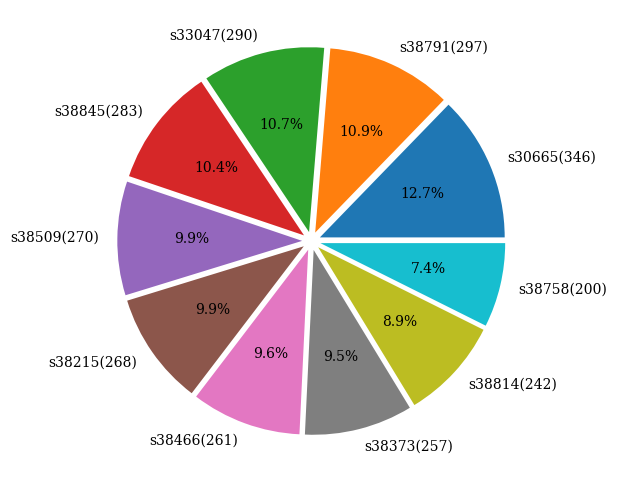

In [69]:
print(f'Number of sightlines: {sbid_counts.sum()}')

plt.figure(figsize=(6,6))
colors = ['g', 'r']
labels = ['s' + str(sbid[i]) + '(' + str(sbid_counts[i]) + ')' for i in range(len(sbid))]
explode = [0.05]*n_fields
plt.pie(df['sbid'].value_counts(normalize=True)*100, colors=None, labels=labels, explode=explode, autopct='%1.1f%%', shadow=False)
plt.title('')
plt.show()

In [70]:
print(f"Types of ratings: {df['rating'].unique()}")

rating_info = df['rating'].value_counts()
rating_types = rating_info.index.to_list()
print(f'Rating types: {rating_types}')

rating_counts = rating_info.values
print(f'Rating counts: {rating_counts}')

n_ratings = len(rating_types)

Types of ratings: ['A' 'B' 'C' 'D']
Rating types: ['B', 'C', 'A', 'D']
Rating counts: [1869  343  294  208]


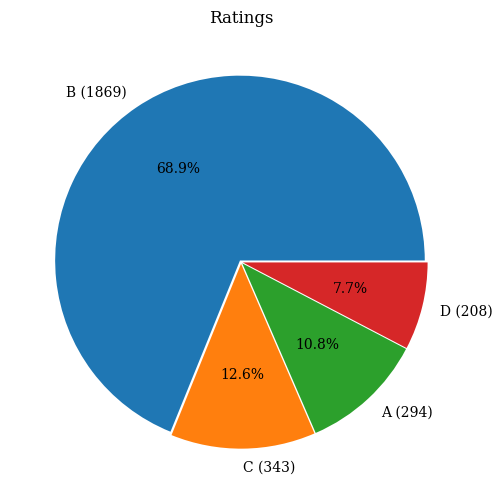

In [71]:
colors = ['g', 'r']
explode = [0.01]*n_ratings
labels = [rating_types[i]+' (' + str(rating_counts[i]) + ')' for i in range(n_ratings)]

plt.figure(figsize=(6,6))
plt.pie(df['rating'].value_counts(normalize=True)*100,
        colors=None,
        labels=labels,
        explode=explode,
        autopct='%1.1f%%',
        shadow=False)

plt.title('Ratings')
plt.show()

# Dectections

In [72]:
det_df = df[df.mw_detection]
print(det_df.shape)
ndet = det_df.shape[0]

det_src_list = det_df.comp_name.values
det_src_gl = det_df.glon.values
det_src_gb = det_df.glat.values

(462, 33)


# Saturated sources

In [74]:
sat_df = df[df.saturated]
sat_df

,id,comp_name,component_id,ra,dec,glon,glat,rating,flux_peak,flux_int,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,min_opacity,vel_min_opacity,peak_tau,e_peak_tau,has_mw_abs,has_other_abs,semi_maj_axis,semi_min_axis,pa,n_h,noise_flag,continuum_slope,field,all_sbids,sbid,mw_detection,saturated
1462,337,J033454-765712,SB38509_component_225a,53.727799,-76.953516,292.330669,-36.594138,B,18.247999,27.194000,0.000092,0.156399,1.429323,2.623784,1.394428,89.0,-0.034895,5.213831,5.0,3.462193,True,False,6.060,4.850,176.830002,2.441017e+20,False,0.009408,M355-07,38509,38509,False,True
1565,244,J042645-754356,SB38758_component_131a,66.689082,-75.732415,288.902586,-34.845820,C,31.113001,34.987999,0.000157,0.162031,1.613970,2.473195,1.464693,71.0,-0.149277,4.435788,5.0,3.546635,True,False,5.065,4.260,55.369999,2.455275e+20,False,0.011692,M355-02,38758,38758,False,True
1576,287,J040852-721901,SB38758_component_156a,62.220323,-72.317006,286.012697,-37.626103,C,25.906000,32.137001,0.000112,0.213407,1.647171,2.575310,1.460707,58.0,-0.186464,6.679087,5.0,3.755119,True,False,5.330,4.465,65.930000,1.192325e+20,False,0.012949,M355-02,38758,38758,False,True
1603,362,J035607-735425,SB38758_component_210a,59.030638,-73.907151,288.329734,-37.514114,C,19.132999,24.773001,0.000095,0.187999,1.734289,1.665929,1.650538,88.0,-0.083751,0.249388,5.0,3.669418,True,False,5.475,4.540,42.380001,2.405412e+20,False,0.009862,M355-02,38758,38758,False,True
2040,350,J040428-692618,SB38814_component_209a,61.118584,-69.438462,283.100898,-39.422719,C,20.837000,24.475000,0.000103,0.253419,1.949616,1.446376,1.796941,104.0,-0.152676,-2.814305,5.0,3.781250,True,False,5.405,4.100,54.599998,4.971288e+19,False,0.002216,M355+02,38814,38814,False,True
2147,110,J053821-771905,SB38845_component_63a,84.590892,-77.318269,288.944277,-30.404877,C,55.574001,69.519997,0.000205,0.183898,1.653708,1.772035,1.596568,103.0,-0.057140,3.886166,5.0,3.657670,True,False,5.320,4.570,40.900002,1.832042e+20,False,0.014752,M000-02,38845,38845,False,True
2148,111,J053821-771856,SB38845_component_63b,84.588785,-77.315712,288.941479,-30.405840,C,42.478001,54.595001,0.000196,0.174150,1.647953,1.944636,1.559646,94.0,-0.088307,3.884371,5.0,3.603101,True,False,5.410,4.620,44.450001,1.832042e+20,False,0.013924,M000-02,38845,38845,False,True
2234,274,J045859-754650,SB38845_component_171b,74.746789,-75.780713,287.956296,-33.026360,B,16.715000,24.173000,0.000146,0.131266,1.445027,2.826273,1.377659,91.0,-0.067368,4.827469,5.0,3.343459,True,False,5.660,4.970,31.719999,2.820502e+20,False,-0.003037,M000-02,38845,38845,False,True
2324,442,J061332-742400,SB38845_component_289a,93.385278,-74.400240,285.348760,-28.592825,C,15.986000,25.902000,0.000069,0.139208,2.103440,1.627650,1.800502,177.0,-0.302938,2.906457,5.0,3.363643,True,False,6.240,5.050,74.209999,7.335645e+19,True,0.006051,M000-02,38845,38845,False,True
2383,0,J032723-744843,SB38509_component_138a,51.846610,-74.812165,290.789024,-38.410531,C,27.474001,28.622999,0.000132,0.282384,2.663230,1.603476,2.022952,67.0,-0.640278,2.955655,5.0,4.080212,True,False,4.855,4.230,41.660000,0.000000e+00,False,-0.010134,M355-07,"38466,38509,38758",38509,False,True


In [76]:
sat_gl = sat_df.glon.values
sat_gb = sat_df.glat.values
nsat = len(sat_gl)
nsat

12

# GASKAP Tbpeak

In [80]:
# Tb,peak map
tbpeak_data_file = LMC_data_path / 'Tb_peak_combined_mw_full_hnv.fits'

tbpeak_map, hdr = fits.getdata(tbpeak_data_file, header=True)
wcs2D = WCS(hdr)
print(wcs2D)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 56.755694111202  -72.799170553189  
CRPIX : 2550.0  1750.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.00666666  0.00666666  
NAXIS : 5100  3500


In [89]:
outfile1 = LMC_data_path / 'Tbmax_Pilot_II_askap_parkes_PBC_30_arcs_FG_GASS_lb_tan.fits'
nx1 = 5100
nx2 = 3500

In [91]:
print(outfile1)
tbpeak_data, fg_hdr = fits.getdata(outfile1, header=True)
print(tbpeak_data.shape)
fg_hdr

/Users/kiemhiep/ANU/ASKAP/data/LMC/Tbmax_Pilot_II_askap_parkes_PBC_30_arcs_FG_GASS_lb_tan.fits
(3500, 5100)


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 5100                                                  
NAXIS2  =                 3500                                                  
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =               2550.0 / Pixel coordinate of reference point            
CRPIX2  =               1750.0 / Pixel coordinate of reference point            
CDELT1  =          -0.00666666 / [deg] Coordinate increment at reference point  
CDELT2  =           0.00666666 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'GLON-TAN'        

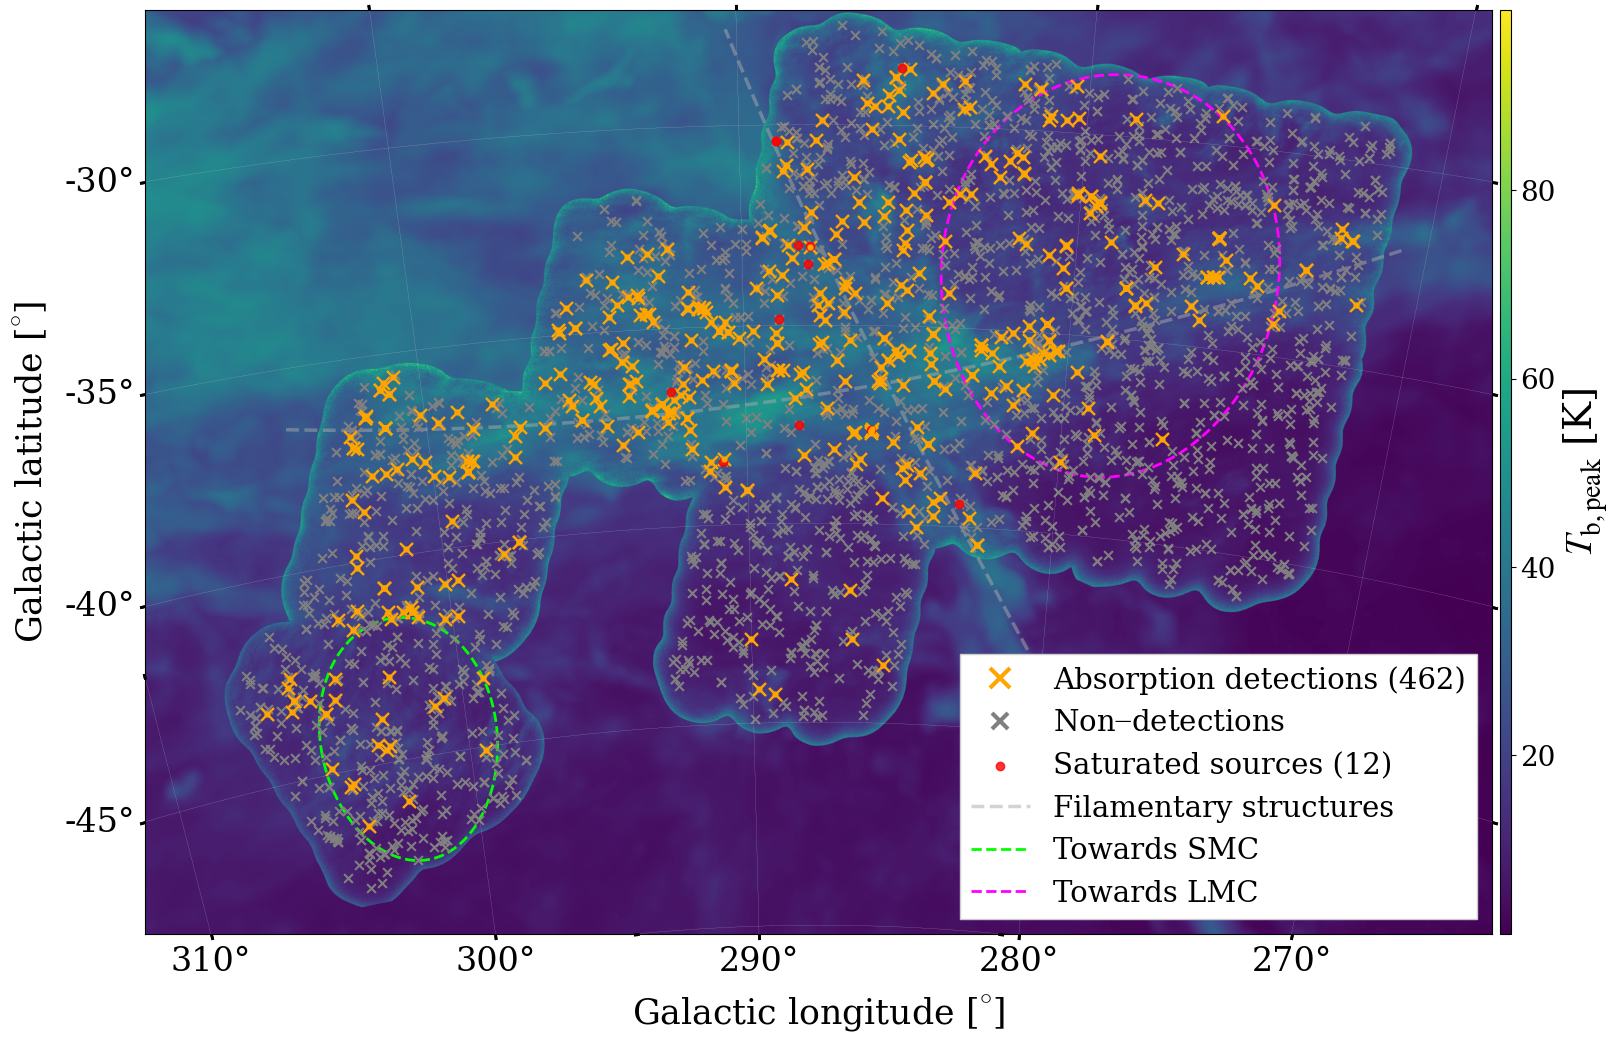

In [99]:
# Plot
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, projection=WCS(fg_hdr))

# Display the moment map image
im = ax.imshow(tbpeak_data, cmap='viridis')

ax.scatter(det_src_gl, det_src_gb,
                 s=85,
                 transform=ax.get_transform('galactic'),
                 marker='x',
                 c='orange',
                 alpha=1,
                 label='')
ploti, = ax.plot([4000], [100], c='orange', marker='x', markersize=15, mew=3, ls='', lw=0, label=f'Absorption detections ({ndet})')
ploti.set_visible(True)

ax.scatter(src_gl, src_gb,
                 s=40,
                 transform=ax.get_transform('galactic'),
                 marker='x',
                 c='gray', # cadetblue
                 alpha=1,
                 label='')


ploti, = ax.plot([4000], [100], c='gray', marker='x', markersize=12, mew=3, ls='', lw=0, label='Non$-$detections')
ploti.set_visible(True)

ax.scatter(det_src_gl, det_src_gb,
                 s=85,
                 transform=ax.get_transform('galactic'),
                 marker='x',
                 c='orange',
                 alpha=1,
                 )

ax.scatter(sat_gl, sat_gb, s=36, transform=ax.get_transform('galactic'), marker='o', c='r', alpha=0.8, label=f'Saturated sources ({nsat})')
ax.scatter(det_src_gl, det_src_gb, s=12, marker='o', c='orange', alpha=1., transform=ax.get_transform('galactic'), label='')



# ax.plot(gl_boundary, gb_boundary, ls='--', c='skyblue', transform=ax.get_transform('galactic'))

ax.plot(ch_xcirc, ch_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.5,
        c='darkgray',
        ls='--',
        zorder=0,
        alpha=0.5,
        label='Filamentary structures'
       )


ax.plot(cv_xcirc, cv_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.5,
        c='darkgray',
        ls='--',
        zorder=0,
        alpha=0.5,
        label=''
       )


# # Approximate locations of LMC, SMC
ax.plot(SMC_xcirc,
        SMC_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.,
        zorder=0,
        color='lime',
        ls='--',
        label='Towards SMC'
       )
ax.plot(LMC_xcirc,
        LMC_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.,
        zorder=0,
        color='fuchsia',
        ls='--',
        label='Towards LMC'
       )

# Add axes labels
ax.set_xlabel("Galactic Longitude [degrees]", fontsize=16)
ax.set_ylabel("Galactic Latitude [degrees]", fontsize=16)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', location='right', fraction=0.008, pad=0.005, aspect=85)
cbar.ax.set_ylabel('$T_\mathrm{b,peak}$ [K]', rotation=90, labelpad=5., fontsize=28)
cbar.ax.tick_params(labelsize=20)


# Add axes labels
ax.set_xlabel(r'Galactic longitude [$^{\circ}$]', fontsize=25)
ax.set_ylabel(r'Galactic latitude [$^{\circ}$]', fontsize=25)

ax.tick_params(axis='x', labelsize=24, pad=4)
ax.tick_params(axis='y', labelsize=24)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)


ax.legend(loc='lower right', fancybox=False, framealpha=1., labelcolor='k', facecolor='w', fontsize=21)
ax.grid(True, linestyle='--', linewidth=0.15, color='lightgray', zorder=-10)
plt.show()